In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np
import matplotlib as mpl
import time

import csv
import pandas as pd
import math
from tqdm import tqdm

import itertools
from collections import defaultdict

In [3]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife/nutria
oregon_wildlife/raccoon
oregon_wildlife/cougar
oregon_wildlife/bald_eagle
oregon_wildlife/black_bear
oregon_wildlife/virginia_opossum
oregon_wildlife/deer
oregon_wildlife/raven
oregon_wildlife/sea_lions
oregon_wildlife/red_fox

total img num: 7168


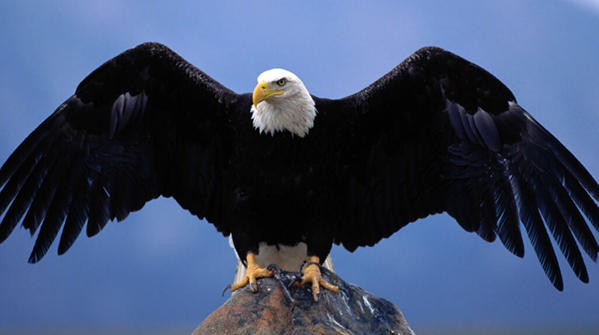

bald_eagle


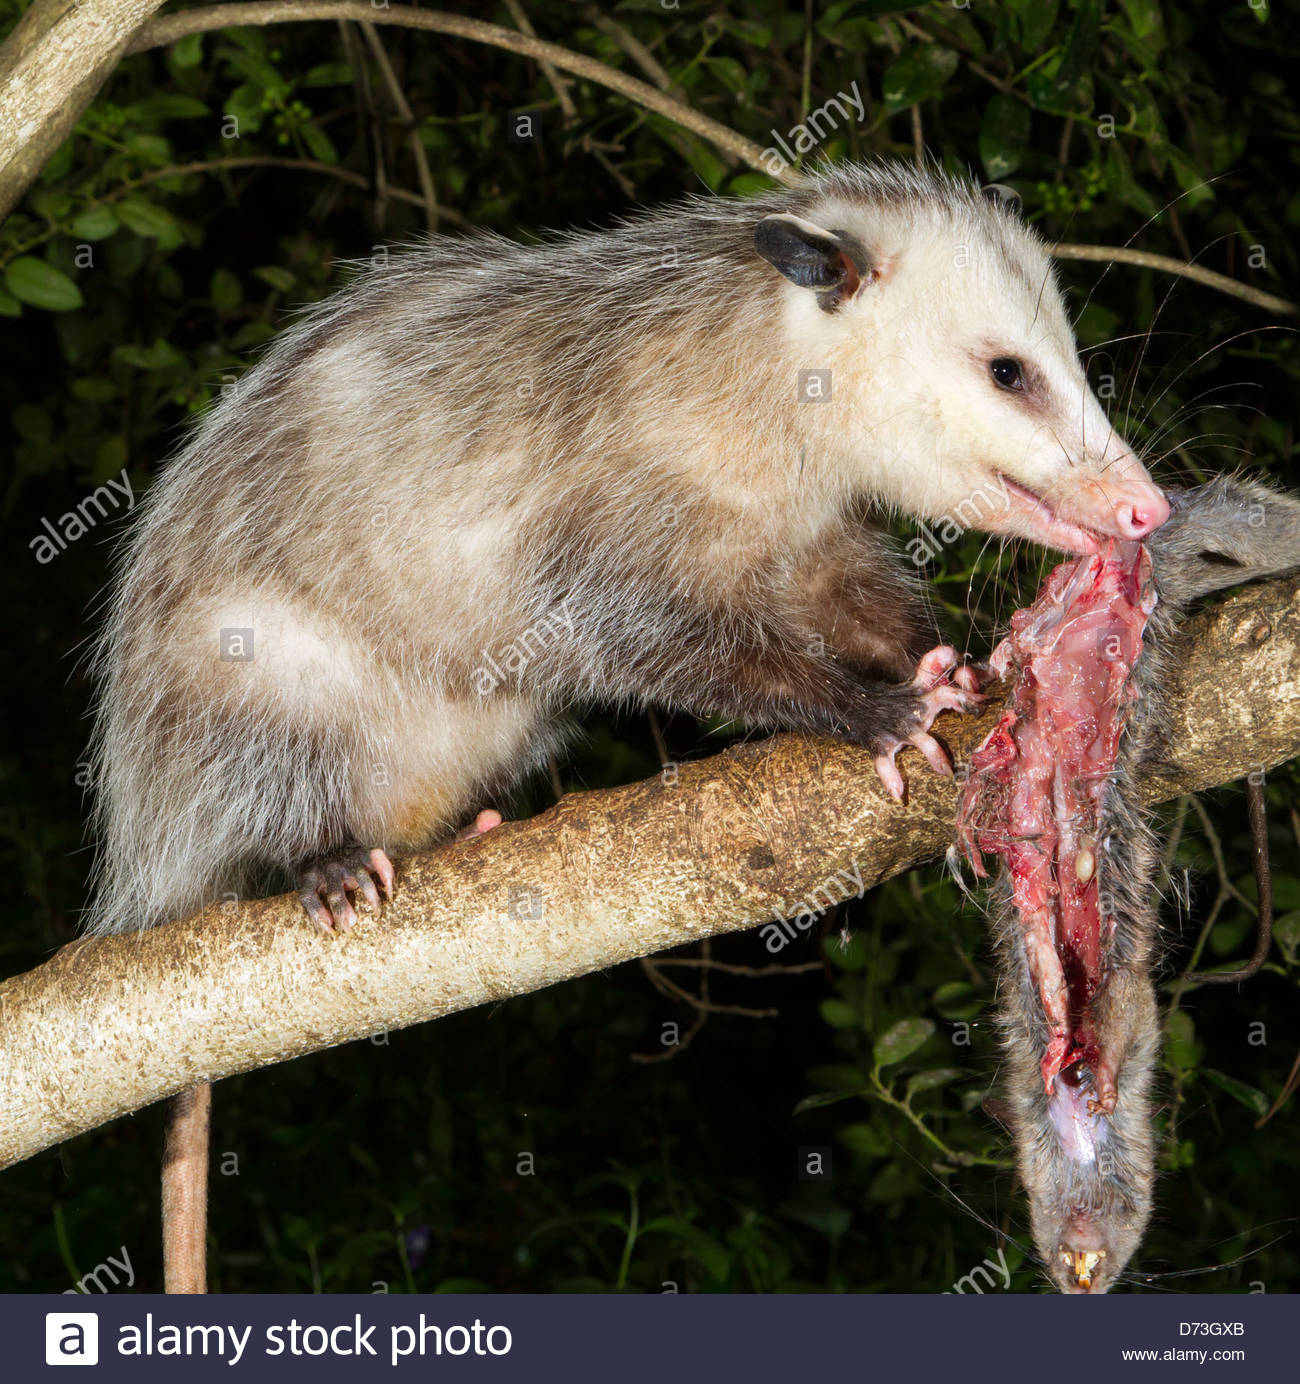

virginia_opossum


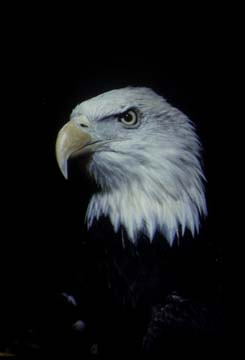

bald_eagle


In [4]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-2])


In [5]:
# get the label
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total label
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [6]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [7]:
# get the label data
all_image_label = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 label indices: ", all_image_label[:10])

First 10 label indices:  [8, 9, 2, 9, 5, 2, 5, 4, 5, 4]


In [8]:
# Create training and testing sets using an 80-20 split
img_path_train, img_path_test, label_train, label_test = train_test_split(all_image_paths,
                                all_image_label,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_test)))


training data: 5734
testing data: 1434


In [9]:
# save (img_path, label) pairs
with open('train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_train, label_train):
        writer.writerow([img_path, label])
        
with open('test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_test, label_test):
        writer.writerow([img_path, label])

In [10]:
# Feel free to change IMAGE_SIZE_CROPPED if using random_crop in your data augmentation process, but make sure the input resize back to (300,300,3) before feed into VGG16
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

In [11]:
# construct a new dataset with time informantion
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE=(
        tf.TensorSpec(shape=(2, 1), dtype=tf.string), # steps: [("Open",), ("Read",)]
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32), # timings: [(open_enter, open_elapsed), (read_enter, read_elapsed)]
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32), # counters: [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, example_idx)]
        tf.TensorSpec(shape=(300,300,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32) # label
    )

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename, open_file, read_file):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        img_paths, label = open_file(filename)
        open_elapsed = time.perf_counter() - open_enter
        # ----------------
        
        # Reading the file        
        for sample_idx in range(len(img_paths)):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            img = read_file(img_paths[sample_idx])
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                img,
                label[sample_idx]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, filename, open_file, read_file):
        def generator_func(instance_idx, filename):
            return cls._generator(instance_idx, filename, open_file, read_file)

        return tf.data.Dataset.from_generator(
            generator_func,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )

In [12]:
def open_file(filename):
    rows = pd.read_csv(filename.decode("utf-8"))
    img_paths = rows['img_path'].tolist()
    label = rows['label'].tolist()
    return img_paths, label

def read_file(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

def dataset_generator_fun_train(*args):
    return TimeMeasuredDataset('train.csv', open_file, read_file)

def dataset_generator_fun_test(*args):
    return TimeMeasuredDataset('test.csv', open_file, read_file)

In [13]:
# feel free to modify these two Settings.
BUFFER_SIZE = 1000
BATCH_SIZE = 32

dataset_train = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).batch(BATCH_SIZE, drop_remainder=True)
dataset_test = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test).batch(BATCH_SIZE, drop_remainder=True)

tf.Tensor(
[[b'Open']
 [b'Read']], shape=(2, 1), dtype=string) tf.Tensor(
[[1.4889568e+06 1.7852880e-02]
 [1.4889568e+06 4.4061512e-01]], shape=(2, 2), dtype=float32) tf.Tensor(
[[ 0  0 -1]
 [ 0  0  0]], shape=(2, 3), dtype=int32)
(300, 300, 3)


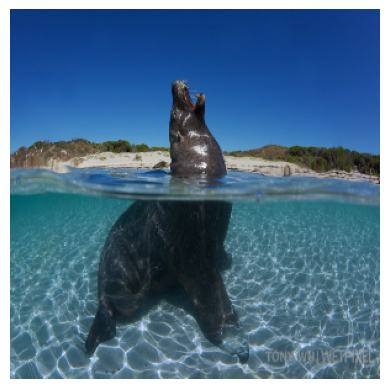

sea_lions


In [14]:
for steps, timings, counters, img, label in dataset_train.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

In [15]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

58892288/58889256 [==============================] - 3s 0us/step


In [16]:
wild_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [17]:
# save the initialization of weights 
wild_model.save_weights('wild_model.h5')

In [18]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [19]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = wild_model(image, training=True)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))

    train_loss(loss)
    train_accuracy(label, predictions)
    
@tf.function
def test_step(image, label):
    predictions = wild_model(image, training=False)
    loss = loss_object(label, predictions)

    test_loss(loss)
    test_accuracy(label, predictions)

In [20]:
def timelined_benchmark(dataset_train, dataset_test, EPOCHS):
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    print("start time: ", start_time)
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()

        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        tf.print("training:")
        for steps, times, values, image, label in tqdm(dataset_train, total=math.floor(len(img_path_train)/BATCH_SIZE)):
            time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            # record training time
            train_enter = time.perf_counter()
            train_step(image, label)
            train_elapsed = time.perf_counter() - train_enter
            
            time.sleep(0.05)
            
            train_time = tf.concat([tf.fill([times.shape[0], 1], train_enter), tf.fill([times.shape[0], 1], train_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Train")], axis=0)
            times_acc = tf.concat([times_acc, train_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)

        tf.print("testing:")
        for steps, times, values, image, label in tqdm(dataset_test, total=math.floor(len(img_path_test)/BATCH_SIZE)):
            time.sleep(0.05)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            test_enter = time.perf_counter()
            test_step(image, label)
            test_elapsed = time.perf_counter() - test_enter
            
            time.sleep(0.05)
            
            test_time = tf.concat([tf.fill([times.shape[0], 1], test_enter), tf.fill([times.shape[0], 1], test_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Test")], axis=0)
            times_acc = tf.concat([times_acc, test_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)
            
        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, test Loss: {:.4f}, test Accuracy: {:.4f}'
        tf.print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               test_loss.result(),
                               test_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat([steps_acc, [["Epoch"]]], axis=0)
        times_acc = tf.concat([times_acc, [(epoch_enter, epoch_elapsed)]], axis=0)
        values_acc = tf.concat([values_acc, [[-1, epoch, -1]]], axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

In [21]:
timeline_Naive = timelined_benchmark(dataset_train, dataset_test, EPOCHS=3)

start time:  1489020.49727023
training:


100%|██████████| 5734/5734 [13:36<00:00,  7.02it/s]

testing:



100%|██████████| 1434/1434 [03:25<00:00,  6.98it/s]

Epoch 1, Loss: 4.7906, Accuracy: 10.6034, test Loss: 2.2887, test Accuracy: 10.7392
training:



100%|██████████| 5734/5734 [13:42<00:00,  6.97it/s]

testing:



100%|██████████| 1434/1434 [03:27<00:00,  6.92it/s]

Epoch 2, Loss: 2.9365, Accuracy: 9.9756, test Loss: 2.2844, test Accuracy: 10.2510
training:



100%|██████████| 5734/5734 [13:42<00:00,  6.97it/s]

testing:



100%|██████████| 1434/1434 [03:28<00:00,  6.89it/s]

Epoch 3, Loss: 2.4119, Accuracy: 10.0977, test Loss: 2.2947, test Accuracy: 9.8326
Execution time: 3082.945845288923


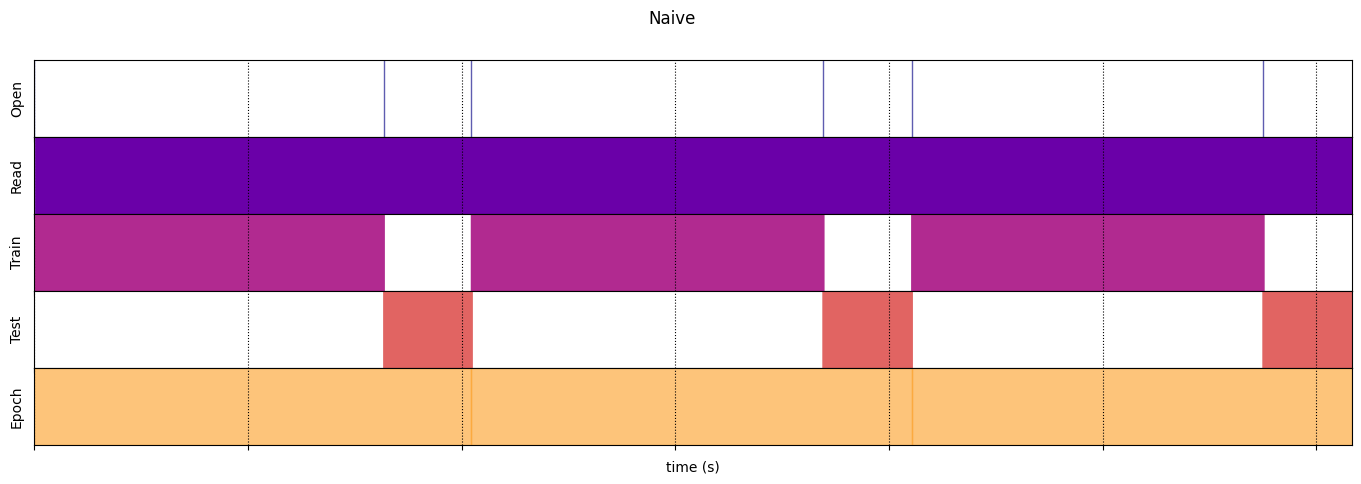

In [22]:
if not os.path.exists("lab11_1_lib.py"):
    urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/11-1_CNN/lab11_1_lib.py", "lab11_1_lib.py")

from lab11_1_lib import draw_timeline
draw_timeline(timeline=timeline_Naive, title="Naive", min_width=3000)

# With data transformation #
What I do : 
  Training : Shuffle before batch, random flip, random brightness, random contrast, standarization
  Testing : standarization


In [38]:
BUFFER_SIZE = 1000
BATCH_SIZE = 256

# parse training data
@tf.function
def map_fun(steps, times, values, image, label):
    map_enter = time.perf_counter()

    distorted_image = tf.image.random_flip_left_right(image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)

    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
        distorted_image,\
        label

# parse testing data
@tf.function
def map_fun_test(steps, times, values, image, label):
    map_enter = time.perf_counter()

    distorted_image = tf.image.per_image_standardization(image)

    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
        tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
        distorted_image,\
        label

In [39]:
## TODO: build `dataset_train_optimized` and `dataset_test_optimized` with transformation and optimization
## Remember to define your own map functions with map_decorator before calling map

dataset_train_augmentation = tf.data.Dataset.range(1)\
                                         .flat_map(dataset_generator_fun_train)\
                                         .shuffle(BUFFER_SIZE)\
                                         .batch(BATCH_SIZE, drop_remainder=True)\
                                         .map(map_fun)

dataset_test_augmentation = tf.data.Dataset.range(1)\
                                        .flat_map(dataset_generator_fun_test)\
                                        .batch(BATCH_SIZE, drop_remainder=True)\
                                        .map(map_fun_test)

In [40]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Augmentation = timelined_benchmark(dataset_train_augmentation, dataset_test_augmentation, EPOCHS=10)

start time:  1495187.981543028
training:


100%|██████████| 22/22 [03:39<00:00,  9.98s/it]

testing:



100%|██████████| 5/5 [00:42<00:00,  8.48s/it]

Epoch 1, Loss: 11.2098, Accuracy: 23.7749, test Loss: 1.1718, test Accuracy: 66.3281
training:



100%|██████████| 22/22 [03:09<00:00,  8.59s/it]

testing:



100%|██████████| 5/5 [00:42<00:00,  8.42s/it]

Epoch 2, Loss: 0.9259, Accuracy: 67.3295, test Loss: 0.4261, test Accuracy: 86.2500
training:



100%|██████████| 22/22 [03:03<00:00,  8.35s/it]

testing:



100%|██████████| 5/5 [00:43<00:00,  8.70s/it]

Epoch 3, Loss: 0.4613, Accuracy: 84.6413, test Loss: 0.2761, test Accuracy: 91.5625
training:



100%|██████████| 22/22 [03:05<00:00,  8.44s/it]

testing:



100%|██████████| 5/5 [00:37<00:00,  7.58s/it]

Epoch 4, Loss: 0.3029, Accuracy: 90.6428, test Loss: 0.2094, test Accuracy: 93.5156
training:



100%|██████████| 22/22 [03:11<00:00,  8.68s/it]

testing:



100%|██████████| 5/5 [00:42<00:00,  8.48s/it]

Epoch 5, Loss: 0.2103, Accuracy: 93.2528, test Loss: 0.1588, test Accuracy: 95.4688
training:



100%|██████████| 22/22 [03:05<00:00,  8.43s/it]

testing:



100%|██████████| 5/5 [00:42<00:00,  8.54s/it]

Epoch 6, Loss: 0.1521, Accuracy: 94.9751, test Loss: 0.1570, test Accuracy: 95.4688
training:



100%|██████████| 22/22 [02:57<00:00,  8.07s/it]

testing:



100%|██████████| 5/5 [00:44<00:00,  8.94s/it]

Epoch 7, Loss: 0.1143, Accuracy: 96.4844, test Loss: 0.1560, test Accuracy: 95.0781
training:



100%|██████████| 22/22 [03:00<00:00,  8.20s/it]

testing:



100%|██████████| 5/5 [00:39<00:00,  7.94s/it]

Epoch 8, Loss: 0.0960, Accuracy: 97.2656, test Loss: 0.1254, test Accuracy: 95.6250
training:



100%|██████████| 22/22 [03:02<00:00,  8.29s/it]

testing:



100%|██████████| 5/5 [00:38<00:00,  7.75s/it]

Epoch 9, Loss: 0.1023, Accuracy: 96.6442, test Loss: 0.1219, test Accuracy: 95.9375
training:



100%|██████████| 22/22 [03:07<00:00,  8.53s/it]

testing:



100%|██████████| 5/5 [00:40<00:00,  8.18s/it]

Epoch 10, Loss: 0.0716, Accuracy: 97.9226, test Loss: 0.1273, test Accuracy: 95.8594
Execution time: 2298.2494374269154


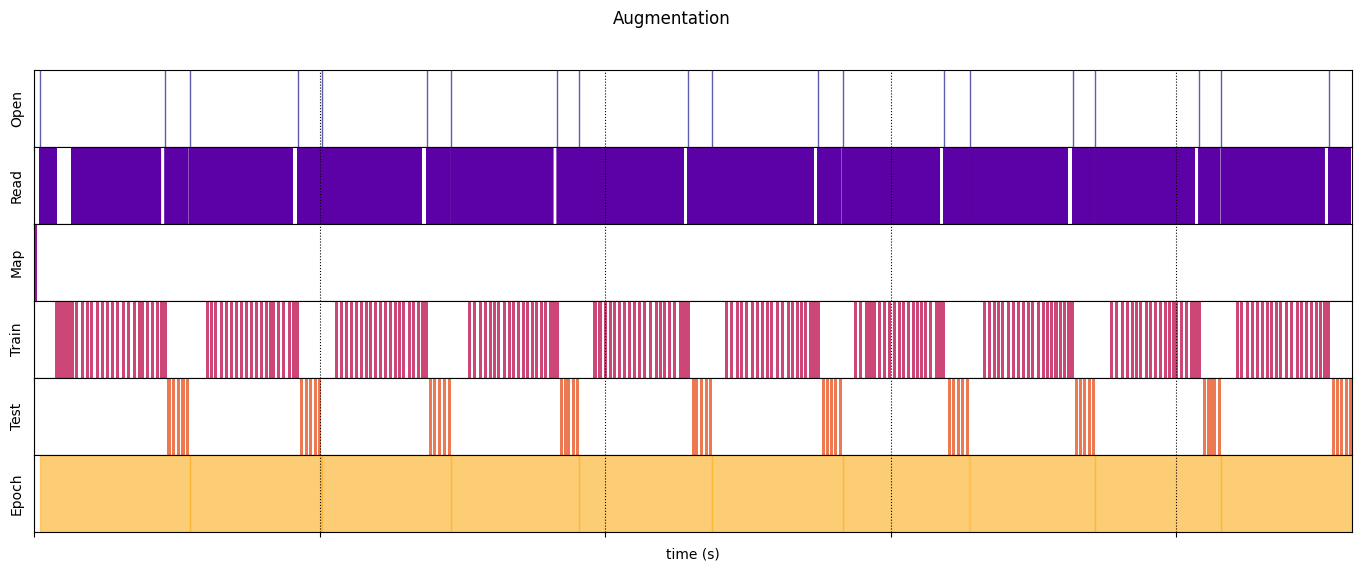

In [41]:
draw_timeline(timeline=timeline_Augmentation, title="Augmentation", min_width=1000)

In [35]:
## TODO: build `dataset_train_optimized` and `dataset_test_optimized` with transformation and optimzation
## Remember to re-define your own map functions again to make mapping time re-calculated

BUFFER_SIZE = 1000
BATCH_SIZE = 128

dataset_train_optimized = tf.data.Dataset.range(1)\
                                         .interleave(dataset_generator_fun_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                                         .shuffle(BUFFER_SIZE)\
                                         .batch(BATCH_SIZE, drop_remainder=True)\
                                         .map(map_fun, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                                         .cache()\
                                         .prefetch(tf.data.experimental.AUTOTUNE)
dataset_test_optimized = tf.data.Dataset.range(1)\
                                        .interleave(dataset_generator_fun_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                                        .batch(BATCH_SIZE, drop_remainder=True)\
                                        .map(map_fun_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                                        .cache()\
                                        .prefetch(tf.data.experimental.AUTOTUNE)

In [36]:
wild_model.load_weights('wild_model.h5')
timeline_Optimized = timelined_benchmark(dataset_train_optimized, dataset_test_optimized, EPOCHS=10)

start time:  1494478.058539849
training:


100%|██████████| 44/44 [02:33<00:00,  3.50s/it]

testing:



100%|██████████| 11/11 [00:40<00:00,  3.69s/it]

Epoch 1, Loss: 9.5341, Accuracy: 39.3466, test Loss: 0.6424, test Accuracy: 81.3210
training:



100%|██████████| 44/44 [00:21<00:00,  2.05it/s]

testing:



100%|██████████| 11/11 [00:05<00:00,  2.12it/s]

Epoch 2, Loss: 0.6323, Accuracy: 79.3679, test Loss: 0.3864, test Accuracy: 87.6420
training:



100%|██████████| 44/44 [00:21<00:00,  2.05it/s]

testing:



100%|██████████| 11/11 [00:05<00:00,  2.11it/s]

Epoch 3, Loss: 0.3441, Accuracy: 88.7429, test Loss: 0.2686, test Accuracy: 92.6136
training:



100%|██████████| 44/44 [00:21<00:00,  2.06it/s]

testing:



100%|██████████| 11/11 [00:05<00:00,  2.11it/s]

Epoch 4, Loss: 0.2185, Accuracy: 92.5959, test Loss: 0.2359, test Accuracy: 93.1818
training:



100%|██████████| 44/44 [00:21<00:00,  2.04it/s]

testing:



100%|██████████| 11/11 [00:05<00:00,  2.11it/s]

Epoch 5, Loss: 0.1733, Accuracy: 94.6910, test Loss: 0.2464, test Accuracy: 93.0398
training:



100%|██████████| 44/44 [00:21<00:00,  2.04it/s]

testing:



100%|██████████| 11/11 [00:05<00:00,  2.10it/s]

Epoch 6, Loss: 0.1185, Accuracy: 96.4666, test Loss: 0.2194, test Accuracy: 93.3949
training:



100%|██████████| 44/44 [00:21<00:00,  2.04it/s]

testing:



100%|██████████| 11/11 [00:05<00:00,  2.11it/s]

Epoch 7, Loss: 0.0944, Accuracy: 96.9815, test Loss: 0.2449, test Accuracy: 93.8920
training:



100%|██████████| 44/44 [00:21<00:00,  2.04it/s]

testing:



100%|██████████| 11/11 [00:05<00:00,  2.10it/s]

Epoch 8, Loss: 0.0732, Accuracy: 97.5852, test Loss: 0.2334, test Accuracy: 93.7500
training:



100%|██████████| 44/44 [00:21<00:00,  2.03it/s]

testing:



100%|██████████| 11/11 [00:05<00:00,  2.10it/s]

Epoch 9, Loss: 0.0702, Accuracy: 97.7628, test Loss: 0.2449, test Accuracy: 93.9631
training:



100%|██████████| 44/44 [00:21<00:00,  2.03it/s]

testing:



100%|██████████| 11/11 [00:05<00:00,  2.08it/s]

Epoch 10, Loss: 0.0478, Accuracy: 98.3842, test Loss: 0.2547, test Accuracy: 94.1051
Execution time: 435.7908696879167


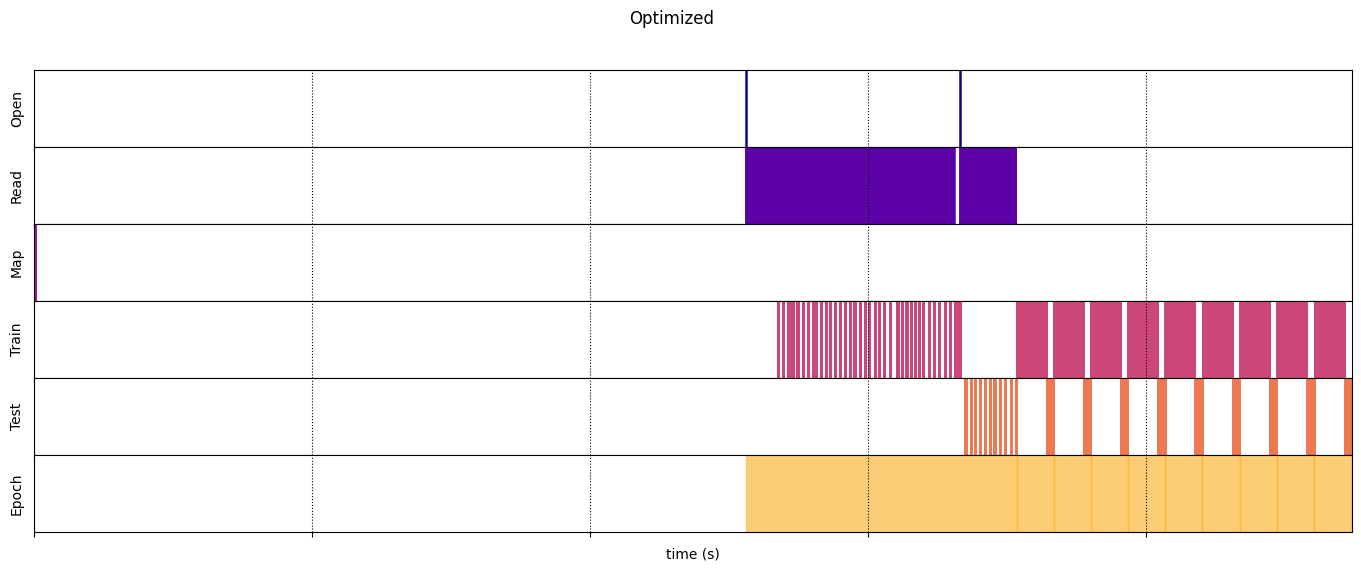

In [37]:
draw_timeline(timeline_Optimized, "Optimized", 500)

# Summary #
如果做了 transformation, accuracy 會有很大的上升, 這也跟理論相符 (dataset 越大, acc 越大)
同時很明顯的 training time 也會直線上升 ,但是這可以靠 pipeline optimization 來降低 training time(training time 有大幅度地降低 , 大約是1/5甚至更多, 可以發現 data 存到了 cache), 只是我不懂的點是 pipeline optimization 的 acc 為什麼會降低？ 我猜測應該是 random seed 不同所導致, 因為 train 的 epoch 數是相同的, 我認為降低是不合理的. 

| Method                                  | Training Accuracy (%) | Validating Accuracy (%) | Time Consuming (sec.) |
|-----------------------------------------|-----------------------|-------------------------|-----------------------|
| Original                                | 10.10                 | 9.832                   | 3082                  |
| With transformation                     | 97.92                 | 95.85                   | 2298                  |
| With transformation and optimization    | 98.38                 | 94.11                   | 435                   |
